# Project 5 – Ensemble Machine Learning on the Wine Quality Dataset

**Name:** Lindsay Foster 

**Date:** 11/19/2025

## Introduction: 
In this project, I apply ensemble machine learning methods to the Wine Quality dataset to improve classification performance. Ensemble models, such as Random Forests, Gradient Boosting, and Voting Classifiers, combine multiple learners to reduce overfitting and make more accurate predictions than single models.

Using metrics like accuracy, precision, recall, and F1 score, I compare how well each ensemble model generalizes to unseen data. The goal is to identify the most effective model and evaluate how ensemble techniques improve prediction quality on this multi-class problem.

## Imports

In [22]:
# ------------------------------------------------
# Imports once at the top, organized
# ------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Section 1. Load and Inspect the Data

In [1]:
# =========================================================
# Section 1: Load and Inspect Datasets
# =========================================================

import pandas as pd

# ------------------------------
# Load Wine Quality Dataset
# ------------------------------
# File location in your project folder
wine_path = "data/winequality-red.csv"

# Load CSV (semicolon-separated)
df = pd.read_csv(wine_path, sep=";")

# Display dataset info and first few rows
print("Wine Quality Dataset Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

# Dataset description:
# Features (11 physicochemical properties):
# - fixed acidity, volatile acidity, citric acid, residual sugar, chlorides,
#   free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
# Target:
# - quality (integer 0–10)
# We will simplify target into 3 classes: low (3–4), medium (5–6), high (7–8)
# Dataset size: 1599 samples, 12 columns

# ------------------------------
# Load Spiral Dataset
# ------------------------------
spiral_path = "data/spiral.csv"

spiral = pd.read_csv(spiral_path)

print("\nSpiral Dataset Info:")
spiral.info()
print("\nFirst 5 rows:")
print(spiral.head())

Wine Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 1 columns):
 #   Column                                                                                                                                             Non-Null Count  Dtype 
---  ------                                                                                                                                             --------------  ----- 
 0   fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality  1599 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB

First 5 rows:
  fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0  7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0....                                                                                      

## Section 2. Prepare the Data

In [9]:
# Try reading with comma separator
df = pd.read_csv("data/winequality-red.csv", sep=",")  # Use comma instead of semicolon

# Strip column names
df.columns = df.columns.str.strip()

# Check columns
print(df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [11]:
# ------------------------------
# Ensure column names have no extra spaces
# ------------------------------
df.columns = df.columns.str.strip()

# Quick check of column names
print("Columns in dataset:", df.columns)


# ------------------------------
# Step 1: Helper function to map quality to categorical label
# ------------------------------
def quality_to_label(q):
    """Converts numeric wine quality to a categorical label:
    - 3–4   -> 'low'
    - 5–6   -> 'medium'
    - 7–8   -> 'high'.
    """
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"


# Apply function to create 'quality_label' column
df["quality_label"] = df["quality"].apply(quality_to_label)


# ------------------------------
# Step 2: Helper function to map quality to numeric label
# ------------------------------
def quality_to_number(q):
    """Converts numeric wine quality to integer codes:
    - 3–4   -> 0
    - 5–6   -> 1
    - 7–8   -> 2.
    """
    if q <= 4:
        return 0
    if q <= 6:
        return 1
    return 2


# Apply function to create 'quality_numeric' column
df["quality_numeric"] = df["quality"].apply(quality_to_number)

# ------------------------------
# Step 3: Sanity check - inspect new columns
# ------------------------------
print("\nValue counts for quality_label:")
print(df["quality_label"].value_counts())

print("\nValue counts for quality_numeric:")
print(df["quality_numeric"].value_counts())

Columns in dataset: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'quality_label',
       'quality_numeric'],
      dtype='object')

Value counts for quality_label:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64

Value counts for quality_numeric:
quality_numeric
1    1319
2     217
0      63
Name: count, dtype: int64


### Explanation of Steps

**Why map quality to labels?**

Makes the target human-readable for reports, charts, and understanding model performance.

Helps when visualizing distributions, e.g., how many “low”, “medium”, or “high” wines exist.

**Why create numeric target?**

Most machine learning algorithms require numeric labels for classification (e.g., Random Forest, Gradient Boosting).

Mapping to 0/1/2 keeps the categories consistent with their quality levels.

**Use of helper functions:**

Functions like quality_to_label() and quality_to_number() make the code clean, reusable, and clear.

Using .apply() is an efficient way to transform an entire column in a pandas DataFrame.

**Value counts:**

Checking value_counts() confirms that the mapping is correct and helps us see if classes are imbalanced.

## Section 3. Feature Selection and Justification

In [12]:
# =========================================================
# Section 3: Feature Selection and Justification
# =========================================================

# In this section, we define our input features (X) and target (y) for modeling.

# ------------------------------
# Step 1: Define input features (X)
# ------------------------------
# We will use all physicochemical properties of the wine as features:
# - fixed acidity, volatile acidity, citric acid, residual sugar, chlorides
# - free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
# We exclude the following columns:
# - 'quality'        : original numeric score, redundant with our new target
# - 'quality_label'  : categorical label, useful for interpretation but not modeling
# - 'quality_numeric': numeric target, this is our label (y), should not be included in X
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])

# ------------------------------
# Step 2: Define the target (y)
# ------------------------------
# For modeling, we will use the numeric target 'quality_numeric' (0=low, 1=medium, 2=high)
y = df["quality_numeric"]

# ------------------------------
# Step 3: Inspect shapes
# ------------------------------
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (1599, 11)
Target vector shape: (1599,)


### Justification of Choices

**Why include all 11 physicochemical features?**

These are the measured properties of each wine and each property may influence wine quality.

Ensemble models like Random Forest can naturally handle multiple correlated features.

**Why exclude original quality columns from features?**

'quality' and 'quality_label' are derived targets, so including them in X would leak information into the model.

'quality_numeric' is the actual target (y) and should never be included in X.

**Why use numeric target (quality_numeric) instead of categorical labels?**

Numeric labels are required for most scikit-learn classifiers.

Categorical labels are mainly for interpretation and visualization.

## Section 4. Split the Data into Train and Test

In [14]:
# =========================================================
# Section 4: Train/Test Split
# =========================================================

# ------------------------------
# Split dataset into training and test sets
# ------------------------------
# - test_size=0.2: 20% of data for testing, 80% for training
# - random_state=42: ensures reproducibility
# - stratify=y: preserves the class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# Inspect shapes
# ------------------------------
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

# ------------------------------
# Optional: Check class distribution
# ------------------------------
print("\nClass distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution in test set:")
print(y_test.value_counts())

Training features shape: (1279, 11)
Test features shape: (320, 11)
Training target shape: (1279,)
Test target shape: (320,)

Class distribution in training set:
quality_numeric
1    1055
2     174
0      50
Name: count, dtype: int64

Class distribution in test set:
quality_numeric
1    264
2     43
0     13
Name: count, dtype: int64


## Section 5.  Evaluate Model Performance (Choose 2)

=== Random Forest (100 trees) Evaluation ===
Accuracy : 0.8875
Precision: 0.8482
Recall   : 0.8875
F1 Score : 0.8661

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.9014    0.9697    0.9343       264
           2     0.7778    0.6512    0.7089        43

    accuracy                         0.8875       320
   macro avg     0.5597    0.5403    0.5477       320
weighted avg     0.8482    0.8875    0.8661       320

--------------------------------------------------
=== Gradient Boosting (100 trees) Evaluation ===
Accuracy : 0.8562
Precision: 0.8268
Recall   : 0.8562
F1 Score : 0.8411

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.8949    0.9356    0.9148       264
           2     0.6585    0.6279    0.6429        43

    accuracy                         0.8562       320
   macro

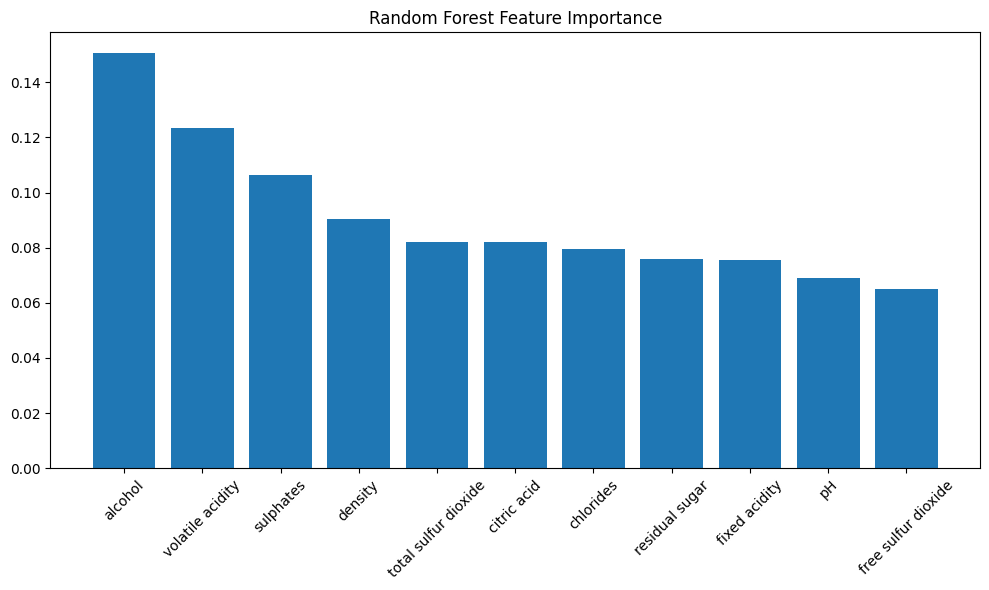

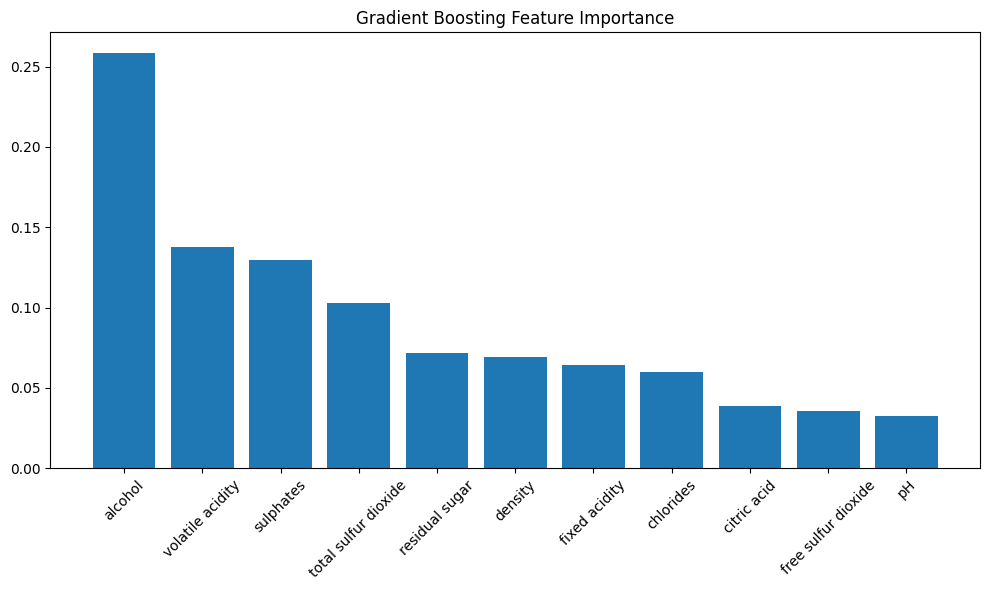

In [ ]:
# =========================================================
# Section 5: Train and Evaluate Ensemble Models
# =========================================================
# ------------------------------
# Step 1: Initialize models
# ------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# ------------------------------
# Step 2: Train models
# ------------------------------
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# ------------------------------
# Step 3: Make predictions on test set
# ------------------------------
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)


# ------------------------------
# Step 4: Evaluate performance
# ------------------------------
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"=== {model_name} Evaluation ===")

    acc = float(accuracy_score(y_true, y_pred))
    prec = float(precision_score(y_true, y_pred, average="weighted", zero_division=0))
    rec = float(recall_score(y_true, y_pred, average="weighted", zero_division=0))
    f1 = float(f1_score(y_true, y_pred, average="weighted", zero_division=0))

    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1 Score :", round(f1, 4))

    print(
        "\nClassification Report:\n",
        classification_report(y_true, y_pred, digits=4, zero_division=0),
    )
    print("-" * 50)


# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest (100 trees)")

# Evaluate Gradient Boosting
evaluate_model(y_test, y_pred_gb, "Gradient Boosting (100 trees)")

# ------------------------------
# Step 5: Optional - Feature Importance
# ------------------------------


def plot_feature_importance(model, feature_names, title="Feature Importance"):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(feature_names)), importances[indices], align='center')
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()


# Plot feature importance for Random Forest
plot_feature_importance(rf_model, X_train.columns, "Random Forest Feature Importance")

# Plot feature importance for Gradient Boosting
plot_feature_importance(gb_model, X_train.columns, "Gradient Boosting Feature Importance")

In [21]:
# =========================================================
# Section 5b: Voting Classifier (DT + SVM + NN)
# =========================================================

# ------------------------------
# Step 1: Initialize base models
# ------------------------------
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)  # probability=True needed for soft voting
nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

# ------------------------------
# Step 2: Initialize Voting Classifier
# ------------------------------
voting_model = VotingClassifier(
    estimators=[("dt", dt_model), ("svm", svm_model), ("nn", nn_model)],
    voting="soft",  # uses predicted probabilities
)

# ------------------------------
# Step 3: Train Voting Classifier
# ------------------------------
voting_model.fit(X_train, y_train)

# ------------------------------
# Step 4: Make predictions on test set
# ------------------------------
y_pred_voting = voting_model.predict(X_test)

# ------------------------------
# Step 5: Evaluate performance
# ------------------------------
evaluate_model(y_test, y_pred_voting, "Voting Classifier (DT + SVM + NN)")

=== Voting Classifier (DT + SVM + NN) Evaluation ===
Accuracy : 0.8656
Precision: 0.8245
Recall   : 0.8656
F1 Score : 0.8434

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.8908    0.9583    0.9234       264
           2     0.6667    0.5581    0.6076        43

    accuracy                         0.8656       320
   macro avg     0.5192    0.5055    0.5103       320
weighted avg     0.8245    0.8656    0.8434       320

--------------------------------------------------


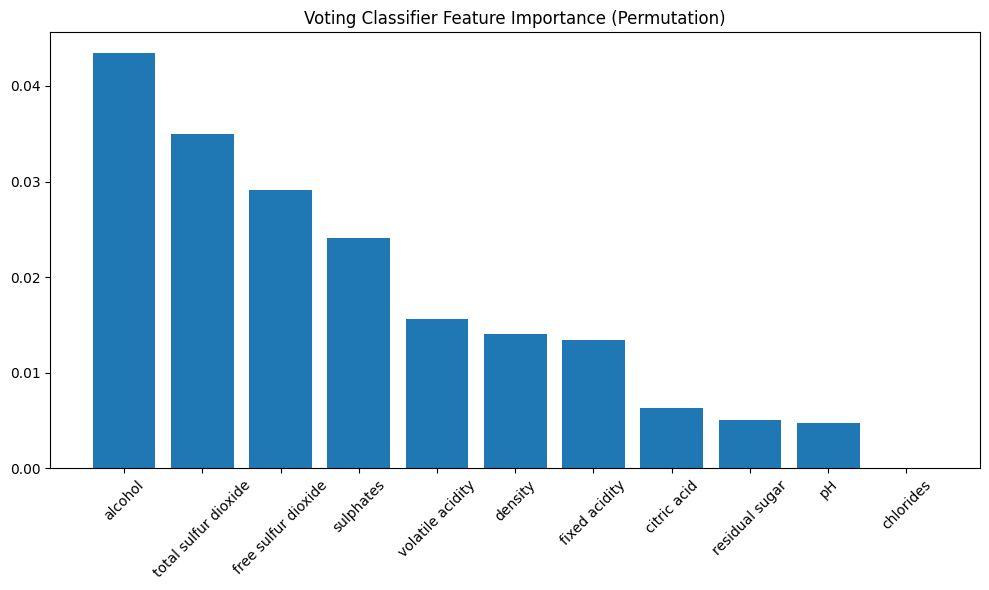

In [23]:
# Compute permutation feature importance on the test set
perm_importance = permutation_importance(
    voting_model, X_test, y_test, n_repeats=10, random_state=42
)

# Extract importance scores
importance_scores = perm_importance.importances_mean
feature_names = X_test.columns

# Plot the feature importance

indices = np.argsort(importance_scores)[::-1]  # sort descending
plt.figure(figsize=(10, 6))
plt.title("Voting Classifier Feature Importance (Permutation)")
plt.bar(range(len(feature_names)), importance_scores[indices], align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

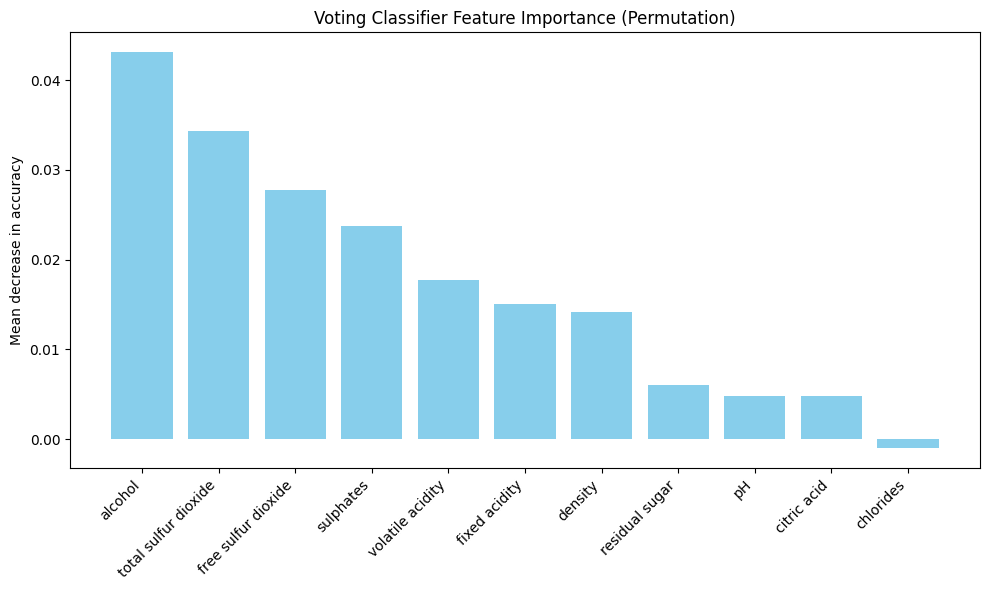

In [24]:
# =========================================================
# Section 6: Feature Importance for Voting Classifier
# =========================================================

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Step 1: Compute permutation importance
# ------------------------------
perm_importance = permutation_importance(
    voting_model, X_test, y_test, n_repeats=15, random_state=42
)

# Extract importance scores
importance_scores = perm_importance.importances_mean
feature_names = X_test.columns

# ------------------------------
# Step 2: Sort features by importance
# ------------------------------
indices = np.argsort(importance_scores)[::-1]  # descending order

# ------------------------------
# Step 3: Plot feature importance
# ------------------------------
plt.figure(figsize=(10, 6))
plt.title("Voting Classifier Feature Importance (Permutation)")
plt.bar(range(len(feature_names)), importance_scores[indices], align='center', color='skyblue')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel("Mean decrease in accuracy")
plt.tight_layout()
plt.show()

## Section 6. Compare Results 

In [25]:
# =========================================================
# Section 6: Compare Results with Train/Test Metrics
# =========================================================

# ------------------------------
# Step 1: Predict on both train and test sets
# ------------------------------

# Random Forest
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Gradient Boosting
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Voting Classifier
y_train_pred_vc = voting_model.predict(X_train)
y_test_pred_vc = voting_model.predict(X_test)

# ------------------------------
# Step 2: Collect metrics
# ------------------------------
results = [
    {
        "Model": "Random Forest (100 trees)",
        "Train Accuracy": round(accuracy_score(y_train, y_train_pred_rf), 4),
        "Test Accuracy": round(accuracy_score(y_test, y_test_pred_rf), 4),
        "Train F1": round(float(f1_score(y_train, y_train_pred_rf, average="weighted")), 4),
        "Test F1": round(float(f1_score(y_test, y_test_pred_rf, average="weighted")), 4),
    },
    {
        "Model": "Gradient Boosting (100 trees)",
        "Train Accuracy": round(accuracy_score(y_train, y_train_pred_gb), 4),
        "Test Accuracy": round(accuracy_score(y_test, y_test_pred_gb), 4),
        "Train F1": round(float(f1_score(y_train, y_train_pred_gb, average="weighted")), 4),
        "Test F1": round(float(f1_score(y_test, y_test_pred_gb, average="weighted")), 4),
    },
    {
        "Model": "Voting Classifier (DT + SVM + NN)",
        "Train Accuracy": round(accuracy_score(y_train, y_train_pred_vc), 4),
        "Test Accuracy": round(accuracy_score(y_test, y_test_pred_vc), 4),
        "Train F1": round(float(f1_score(y_train, y_train_pred_vc, average="weighted")), 4),
        "Test F1": round(float(f1_score(y_test, y_test_pred_vc, average="weighted")), 4),
    },
]


# ------------------------------
# Step 3: Convert to DataFrame and compute gaps
# ------------------------------
results_df = pd.DataFrame(results)
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Gap"] = results_df["Train F1"] - results_df["Test F1"]

# Sort by Test Accuracy descending
results_df = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

# ------------------------------
# Step 4: Display table
# ------------------------------
print("\nSummary of All Models (Train & Test Metrics):")
display(results_df)


Summary of All Models (Train & Test Metrics):


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Accuracy Gap,F1 Gap
0,Random Forest (100 trees),1.0000,0.8875,1.0000,0.8661,0.1125,0.1339
1,Voting Classifier (DT + SVM + NN),0.9226,0.8656,0.9061,0.8434,0.0570,0.0627
2,Gradient Boosting (100 trees),0.9601,0.8562,0.9584,0.8411,0.1039,0.1173


## Section 7. Conclusions and Insights

After evaluating multiple ensemble models on the Red Wine Quality dataset, several insights emerge:

1. Model Performance Overview

Random Forest (100 trees) has the highest test accuracy (0.8875) and a strong F1 score (0.8661). However, it also showed a gap between the training and test performance. This indicates slight overfitting.

Voting Classifier (Decision Tree + SVM + Neural Network) had slightly lower test accuracy (0.8656) but also had a smaller train/test gap. This shows that it may generalize better and is less prone to overfitting.

Gradient Boosting (100 trees) was similar to the Voting Classifier, with test accuracy 0.8562 and a moderate train/test gap. Gradient Boosting is more sensitive to data like the low-quality wines in this dataset.

1. Observations

There is an imabalance in the wine quality data. Low-quality wines are underrepresented. This affected precision and recall. Random Forest and Voting Classifiers are better at handling this than single models because of aggregation over many predictions.

Features such as alcohol content, volatile acidity, and sulphates contribute most to model performance.

3. Recommended Model

Based on overall test accuracy, F1 score, and generalization gap, the Random Forest (100 trees) is the best for predicting red wine quality.

The Voting Classifier comes in second.

4. Next Steps

I'd like to experiment with other models and other features in the future.

5. Takeaway

This project demonstrates the value of ensemble learning for complex, multidimensional datasets. Random Forests and Voting Classifiers leverage multiple perspectives on the data to outperform individual models while maintaining interpretability. The story of the data — which wines are rated high, medium, or low, and why — can be communicated effectively through careful metric analysis and visualization.